# Probabilistic Programming - 1 
## Variational inference

So far you've been doing all your calculations by hand. As you have probably learned, this is timeconsuming and error prone. In this lesson we are going to introduce Probabilistic Programming as a method to automate some of the labour. We will cover 2 software packages: ForneyLab.jl and Turing.jl. We will mainly show you how to specify probabilistic models in both. The main takehome point is that while Probabilistic Programming requires some specialised knowledge in terms of probability theory and Bayesian inference, implementing an inference procedure is straightforward once you have the right tools.

### Preliminaries

- Goal 
  - Learn to write a basic probabilistic program using a variational inference procedure.
- Materials        
  - Mandatory
    - These lecture notes.
    - [Intro to programming in Julia](https://youtu.be/8h8rQyEpiZA?t=233).
    - Getting started with [ForneyLab](https://biaslab.github.io/forneylab/docs/getting-started/).
  - Optional
    - Cheatsheets: [how does Julia differ from Matlab / Python](https://docs.julialang.org/en/v1/manual/noteworthy-differences/index.html).

## Introduction to ForneyLab

[ForneyLab](https://github.com/biaslab/ForneyLab.jl) is a Probabilistic Programming toolbox developed inhouse at [BIASLab](https://biaslab.github.io/). ForneyLab utilises the FFG formalism that you are familiar with by now to describe models. Inference is performed through variational procedures or, if applicable, exact inference. This is the core feature of ForneyLab: A large library of analytical update rules similar to what you have derived so far. This provides fast, deterministic inference with convergence guarantees, provided you supply the right generative model.
Things to keep in mind when using ForneyLab:
1. It is optimised for Dynamical Systems and time series data. It'll be extra fast in these circumstances
2. Relies on deterministic update rules - you will get the same result each time
3. If you find a bug, please tell us :) 

Now, let's work through an example using ForneyLab

### Data generation

In [2]:
using Plots
using Random

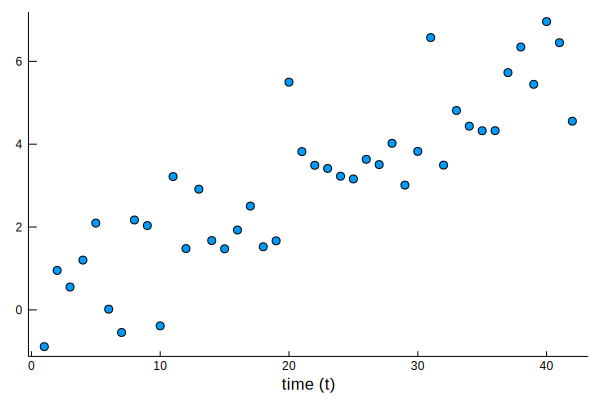

In [5]:
# Parameters
true_W = [1.0;0.5]
true_σ = 1.
true_μ = 0.
true_slope = 0.1

# Length of signal
n = 42
            
function generate_data(true_W, true_σ, true_μ, n)
    
    # Draw from a Gaussian with correct parameters
    x = randn(size(true_W)[1],n) .* true_σ .+ true_μ 
    
    # Add a slope
    [x[:,i] .+= true_slope * i for i in 1:n] 
    
    # Compute y values
    y = true_W' * x 
    
    # List comprehension formats data for easy access later
    return [x[:,i] for i in 1:n],y 
end
   
# Actually generate the data
x_data,y_data = generate_data(true_W,true_σ,true_μ,n)

# Visualize
scatter(1:n,y_data[:], xlabel="time (t)", label="", grid=false)

### Model definition

To model our data, we define a model using ForneyLab. We will try a bayesian linear regression of the form

$$y \sim \mathcal{N}(W^Tx,\sigma_y)$$
With a Gaussian prior on the weights W
$$ W \sim \mathcal{N}(\mathbf{\mu_w},\mathbf{\sigma_w})$$

The first thing we need to do is to import ForneyLab and instantiate a Factor Graph.

In [ ]:
using ForneyLab
g = FactorGraph();

Now that we have a FactorGraph, we can start adding variables to it. This is the point where we specify our probabilistic model. When doing Probabilistic Programming, the core challenge is good model specification. To keep it simple, let's start by defining a model for a single x/y pair.


In [ ]:
# Parameters for priors
μ_w = [0.,0.]
σ_w = [1. 0. ; 0. 1.]
σ_y = 1.

# Let's create a random variable for our input data x. In ForneyLab we use the @RV macro to denote Random Variables
@RV x 

# Now let's define a prior over the weights W. We use a 2 dimensional Gaussian since we have 2 weights
@RV W ~ GaussianMeanVariance(μ_w,σ_w)

# And finally our linear model for y
@RV y ~ GaussianMeanVariance(dot(W,x), σ_y)


# Visualise the graph
ForneyLab.draw()

If you take a look at the graph, you will see that it has some open edges for x and y. This is where we want to feed in our data. To do so in ForneyLab, we designate them as placeholders. This means that we do not give them a value immediately but want them to take one on at a later time - such as when we want to feed in the data.

In [ ]:
placeholder(x,:x, dims=(2,)) # The dims flag tells ForneyLab to expect 2 dimensional inputs here
placeholder(y,:y);

Now that we have our model, it is time to get our inference algorithm. ForneyLab includes the Belief Propagation algorithm for exact inference which we will utilise here. The details of the procedure are not important at this time, so feel free to treat it as a "magic inference button".
ForneyLab works by directly generating new Julia code containing the inference algorithm. When we parse this code, we get a function (step!) which we can then run to execute the inference procedure.

If you are feeling adventurous, feel free to experiment with some of the other inference tools available in ForneyLab. Do you get different results?

In [ ]:
# Generate Julia code for inference. The argument tells ForneyLab which variable we want the posterior for
algo = sumProductAlgorithm(W) 

# Evaluate the generated code to get the step! function
eval(Meta.parse(algo)) 

Next we need to create a dictionary with our data. Since our model is only for a single data point, we create a dictionary holding just one random x/y pair

In [ ]:
data = Dict(:x => x_data[10],
            :y => y_data[10]);

Now, we feed our data dictionary into the step! function, do inference and observe the results! For clarity we have written the model specification below as well so you can get a sense of what a full ForneyLab program looks like.

In [ ]:
g = FactorGraph(); # Instantiate Factor Graph

# Parameters for priors
μ_w = [0.,0.]
σ_w = [1. 0. ; 0. 1.]
σ_y = 1.


# Specify probabilistic model
@RV x 
@RV W ~ GaussianMeanVariance(μ_w,σ_w)
@RV y ~ GaussianMeanVariance(dot(W,x), σ_y)

# Denote placeholders
placeholder(x,:x,dims=(2,)) 
placeholder(y,:y);

# Generate inference algorithm
algo = sumProductAlgorithm(W) 
eval(Meta.parse(algo)) 

# Set up data dictionary
data = Dict(:x => x_data[10],
            :y => y_data[10]);

# Do inference
marginals = step!(data)

# Print results
println("Posterior mean: ",mean(marginals[:W]))
println("Posterior Variance: ",var(marginals[:W]))

That wasn't particurlarly accurate because we only used a single data point. Let's create a new model that takes in the full data set instead and see if we get better results.

In [ ]:
g2 = FactorGraph() # Instantiate new Factor Graph

# Parameters for priors
μ_w = [0.,0.]
σ_w = [1. 0. ; 0. 1.]
σ_y = 1.

# Create vectors to hold variables for all data points
x = Vector{Variable}(undef,n) 
y = Vector{Variable}(undef,n)

# Define a prior over the weights. These are shared for all data points
@RV W ~ GaussianMeanVariance(μ_w,σ_w)

# Loop over the dataset
for i in 1:n
    @RV x[i] # We can use indexing to fill a vector with random variables
    @RV y[i] ~ GaussianMeanVariance(dot(W,x[i]), σ_y) 
    placeholder(x[i],:x,index=i,dims=(2,)) # To define placeholders in vectors, we use the index flag
    placeholder(y[i],:y,index=i)
end

# Generate a new inference algorithm
algo = sumProductAlgorithm(W)
eval(Meta.parse(algo)) 

# Now we can fit the entire data set in our model!
data = Dict(:x => x_data,
            :y => y_data)

# Perform inference and observe the results
marginals = step!(data)
println("Posterior mean: ",mean(marginals[:W]))
println("Posterior Variance: ",var(marginals[:W]))

Much better! The trick to note above is the use of vectors and indices to handle multiple data points. 

#### Assigment 1. 
Generate some new data and change the value of true_$\mu$ to something other than 0. How does the model fit now? Likely not particularly well, since it is missing an intercept term. Your task is to remedy this by extending the regression model to handle intercepts.

Do this by extending the input data with an additional column of 1's and adding an extra weight to W. Can you explain why this works?

In [ ]:
# Your code here